In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

#drive.mount('/content/drive/')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] ='/content/drive/MyDrive/Kaggle'

In [ ]:
%cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
|!unzip \*.zip && rm *.zip

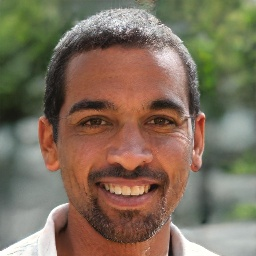

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = "/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/train/fake/76BCVZIK6E.jpg"
image = cv2.imread(img)
cv2_imshow(image)

In [ ]:
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
import cv2

labels = ('real', 'fake')
image_size = 32

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
def get_data(data_dir):
    temp_filename = '/content/sample_data/temp_file_name.jpg'
    ela_filename = '/content/sample_data/temp_ela.png'
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                image = Image.fromarray(resized_arr)
                image = image.convert("RGB")
                image.save(temp_filename,'JPEG', quality = 95)
                temporary_image = Image.open(temp_filename)
                temporary_image.show()
               
                #ELA on images
                ela_image = ImageChops.difference(image, temporary_image)
                extrema = ela_image.getextrema()
                max_diff = max([ex[1] for ex in extrema])
                if max_diff == 0:
                  max_diff = 1
                scale = 255.0 / max_diff
                ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
                ela_image.save(ela_filename, 'JPEG', quality=95)
                imageToDisplay = cv2.imread(ela_filename)
                resized_arr = cv2.resize(imageToDisplay,(image_size,image_size))
               
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

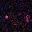

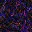

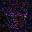

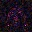

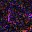

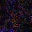

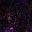

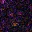

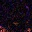

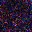

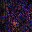

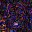

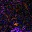

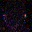

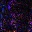

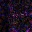

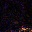

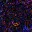

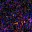

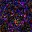

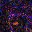

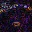

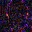

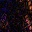

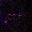

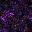

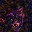

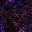

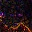

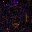

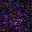

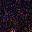

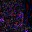

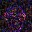

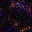

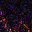

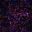

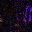

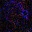

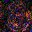

In [ ]:
# need to add my custom data here with ELA pre-processing
import os
num_classes = 2
input_shape = (32, 32, 3)

train = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/train/")
test = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/test/")

print("reading done")

In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append('fake')
    else:
        l.append('real')

In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []

In [ ]:
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [ ]:
X_train = np.array(X_train) #/ 255.0

X_test = np.array(X_test) #/ 255.0


print(X_train.shape)
print(X_test.shape)

(8000, 32, 32, 3)
(2000, 32, 32, 3)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


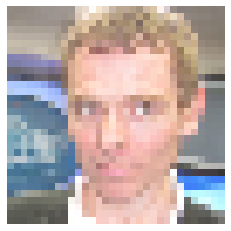

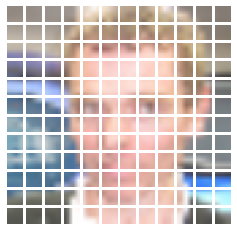

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
    

X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
  

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
29/29 [==============================] - 26s 435ms/step - loss: 1.9007 - accuracy: 0.5456 - top-5-accuracy: 1.0000 - val_loss: 0.6045 - val_accuracy: 0.7038 - val_top-5-accuracy: 1.0000
Epoch 2/100
29/29 [==============================] - 10s 362ms/step - loss: 0.7291 - accuracy: 0.5647 - top-5-accuracy: 1.0000 - val_loss: 0.6983 - val_accuracy: 0.5500 - val_top-5-accuracy: 1.0000
Epoch 3/100
29/29 [==============================] - 11s 365ms/step - loss: 0.6819 - accuracy: 0.5969 - top-5-accuracy: 1.0000 - val_loss: 0.6329 - val_accuracy: 0.6463 - val_top-5-accuracy: 1.0000
Epoch 4/100
29/29 [==============================] - 11s 368ms/step - loss: 0.6575 - accuracy: 0.6192 - top-5-accuracy: 1.0000 - val_loss: 0.7550 - val_accuracy: 0.4175 - val_top-5-accuracy: 1.0000
Epoch 5/100
29/29 [==============================] - 11s 371ms/step - loss: 0.6367 - accuracy: 0.6481 - top-5-accuracy: 1.0000 - val_loss: 0.6987 - val_accuracy: 0.5362 - val_top-5-accuracy: 1.0000
Epoch 6/10

ValueError: ignored

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


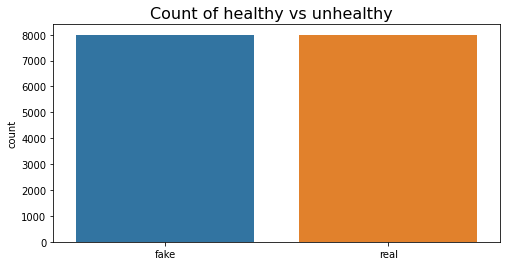

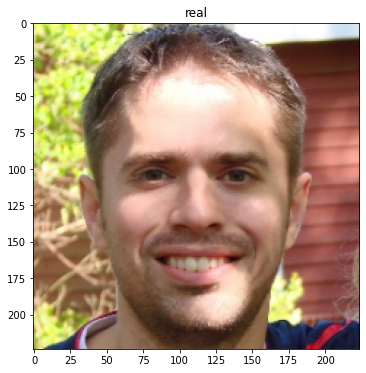

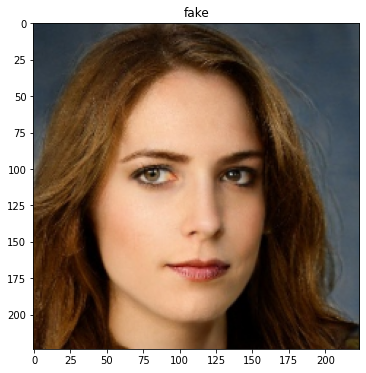

In [ ]:
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt

labels = ('real', 'fake')
image_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')



import os
num_classes = 100
input_shape = (32, 32, 3)

train = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/train/")
test = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/test/")

l = []
for i in train:
    if i[1] == 0:
        l.append('fake')
    else:
        l.append('real')

# visualizing the healthy patients vs the Unhealthy patients
plt.figure(figsize=(8, 4))
plt.title('Count of healthy vs unhealthy  ', size=16)
sns.countplot(x=l)
plt.show()

# randomly visualizing images to see whats going on
plt.figure(figsize=(8, 6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()

X_train = []
X_test = []
y_train = []
y_test = []

# dividing data into train and test sets
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# Normalise the image data (to convert it to range from 0 to 1)
X_train = np.array(X_train) / 255.0

X_test = np.array(X_test) / 255.0


print(X_train.shape)
print(X_test.shape)



learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)



def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")



class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Efficient Net implementation

In [ ]:
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
import cv2

labels = ('real', 'fake')
image_size = 224

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
image_size = 224
labels = ('real', 'fake')
def get_data2(data_dir):
    temp_filename = '/content/sample_data/temp_file_name.jpg'
    ela_filename = '/content/sample_data/temp_ela.png'
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                image = Image.fromarray(resized_arr)
                image = image.convert("RGB")
                image.save(temp_filename,'JPEG', quality = 95)
                temporary_image = Image.open(temp_filename)
                temporary_image.show()
               
                #ELA on images
                ela_image = ImageChops.difference(image, temporary_image)
                extrema = ela_image.getextrema()
                max_diff = max([ex[1] for ex in extrema])
                if max_diff == 0:
                  max_diff = 1
                scale = 255.0 / max_diff
                ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
                ela_image.save(ela_filename, 'JPEG', quality=95)
                imageToDisplay = cv2.imread(ela_filename)
                resized_arr = cv2.resize(imageToDisplay,(image_size,image_size))
               
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

In [ ]:
import os
num_classes = 2

train = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/train/")
test = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/test/")

print("reading done")

reading done


In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append('fake')
    else:
        l.append('real')

In [ ]:
X_train = []
X_test = []
y_train = []
y_test = []

In [ ]:
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [ ]:
X_train = np.array(X_train) #/ 255.0

X_test = np.array(X_test) #/ 255.0


print(X_train.shape)
print(X_test.shape)

(8000, 224, 224, 3)
(2000, 224, 224, 3)


In [ ]:
X_train.reshape(-1, image_size, image_size, 1)
y_train = np.array(y_train)

X_test.reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# By specifying the base_model.trainable=False so ,it prevent the weights in our base model from being
# updated during training.
base_model.trainable = False

# keras tuner to find the best architecture
# GlobalAveragePooling function is use on base model to convert the features into a single vector per image.
# & we add a dropout of 0.2 and the final dense layer with 2 neurons and softmax activation.
model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# callback for early stopping
# patience is the number of epochs wth no improvement after which the training will be stopped
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

258088960/258076736 [==============================] - 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 144s 455ms/step - loss: 0.6732 - accuracy: 0.5880 - val_loss: 0.6871 - val_accuracy: 0.5830
Epoch 2/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6447 - accuracy: 0.6256 - val_loss: 0.6349 - val_accuracy: 0.6370
Epoch 3/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6282 - accuracy: 0.6513 - val_loss: 0.6249 - val_accuracy: 0.6615
Epoch 4/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6202 - accuracy: 0.6529 - val_loss: 0.6229 - val_accuracy: 0.6600
Epoch 5/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6166 - accuracy: 0.6612 - val_loss: 0.6303 - val_accuracy: 0.6455
Epoch 6/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6177 - accuracy: 0.6566 - val_loss: 0.6201 - val_accuracy: 0.6525
Epoch 7/50
250/250 [==============================] - 111s 446ms/step - loss: 0.6140 - accuracy: 0.6603 - val_loss: 0.6263 - val_accura

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.argmax(model.predict(X_test), axis=-1)

# Regain the original shape to evaluate predictions
predictions = predictions.reshape(1, -1)[0]

# Let’s also print the classification report to get more detailed results. (save it to pickel , early stopping)
print(classification_report(y_test, predictions, target_names=['Healthy(class 0)', 'UnHealthy(class 1)']))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# should be 5 for now should be 50
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Vision TRansformer without ELA**

> Indented block



In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
!pip install -U tensorflow-addons
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops, ImageEnhance
import os
import itertools
import random
%matplotlib inline
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 19.0 MB/s 


Function to read the data from respective directories and provide labels for the training and test data

In [ ]:
image_size = 224
labels = ('real', 'fake')
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[..., ::-1]
                resized_arr = cv2.resize(img_arr, (image_size, image_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return np.array(data, dtype='object')

In [ ]:
train = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/train/")
test = get_data("/content/drive/MyDrive/Kaggle/Real_Fake_Dataset/test/")
print(train.shape)
print(test.shape)

(8000, 2)
(2000, 2)


In [ ]:
l = []
for i in train:
    if i[1] == 0:
        l.append('real')
    else:
        l.append('fake')

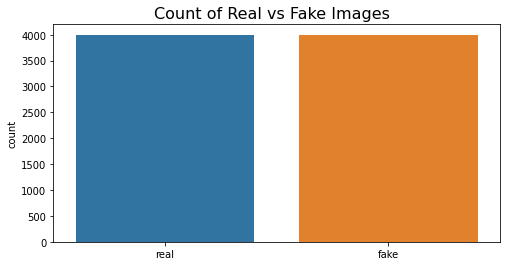

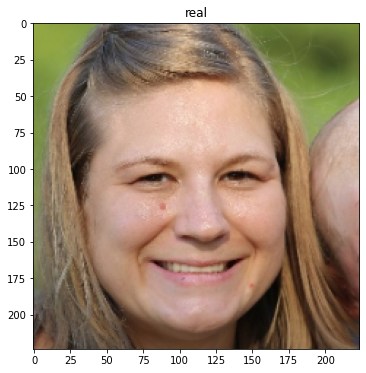

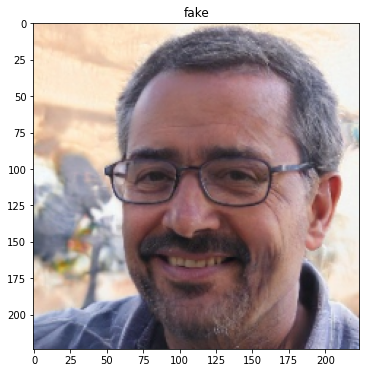

(8000, 224, 224, 3)
(2000, 224, 224, 3)
(8000,)
(2000,)


In [ ]:
plt.figure(figsize=(8, 4))
plt.title('Count of Real vs Fake Images  ', size=16)
sns.countplot(x=l)
plt.show()

# randomly visualizing images to see whats going on
plt.figure(figsize=(8, 6))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])
plt.show()

plt.figure(figsize=(10, 6))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])
plt.show()

X_train = []
X_test = []
y_train = []
y_test = []

# dividing data into train and test sets
for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

# Normalise the image data (to convert it to range from 0 to 1)
X_train = np.array(X_train)# / 255.0

X_test = np.array(X_test) #/ 255.0

# # Reshaping the image data so that every image is the same size
# #X_train.reshape(-1, image_size, image_size, 1)
y_train = np.array(y_train)

# #X_test.reshape(-1, image_size, image_size, 1)

y_test = np.array(y_test)


y_test = np.array(y_test)
print (X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 2
input_shape = (224, 224, 3)

Vision Transformer Parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 80
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train)

Function to create the multilayer perceptron for classification

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Class to generate patches

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Visualizing patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


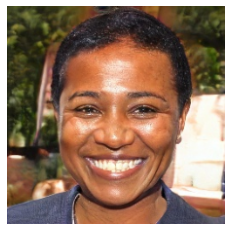

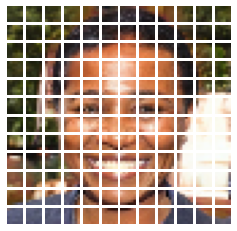

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

Patch encoder class

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Creating the VIT Model

In [ ]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Running the VIT experiment

Epoch 1/80
29/29 [==============================] - 25s 523ms/step - loss: 2.0731 - accuracy: 0.5306 - top-5-accuracy: 1.0000 - val_loss: 0.5721 - val_accuracy: 0.8188 - val_top-5-accuracy: 1.0000
Epoch 2/80
29/29 [==============================] - 14s 486ms/step - loss: 0.7228 - accuracy: 0.5769 - top-5-accuracy: 1.0000 - val_loss: 0.7399 - val_accuracy: 0.3200 - val_top-5-accuracy: 1.0000
Epoch 3/80
29/29 [==============================] - 14s 486ms/step - loss: 0.6829 - accuracy: 0.5924 - top-5-accuracy: 1.0000 - val_loss: 0.8540 - val_accuracy: 0.2550 - val_top-5-accuracy: 1.0000
Epoch 4/80
29/29 [==============================] - 14s 489ms/step - loss: 0.6627 - accuracy: 0.6086 - top-5-accuracy: 1.0000 - val_loss: 0.5848 - val_accuracy: 0.7925 - val_top-5-accuracy: 1.0000
Epoch 5/80
29/29 [==============================] - 15s 501ms/step - loss: 0.6498 - accuracy: 0.6236 - top-5-accuracy: 1.0000 - val_loss: 0.6478 - val_accuracy: 0.6675 - val_top-5-accuracy: 1.0000
Epoch 6/80
29/2

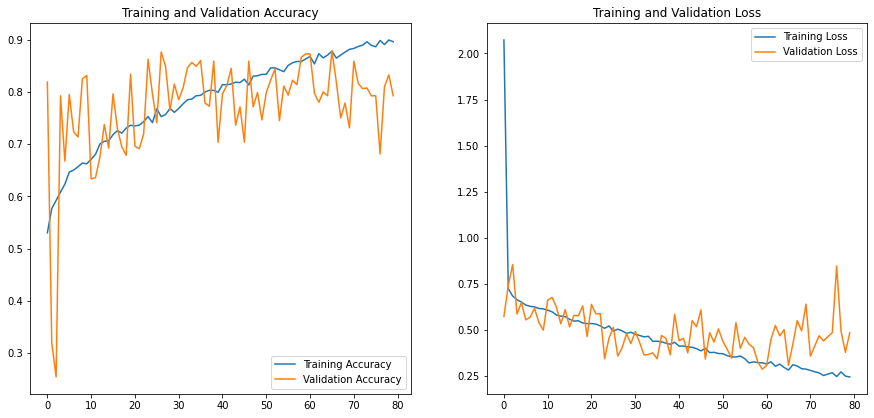

[[0.79576108 0.18087318]
 [0.20423892 0.81912682]]


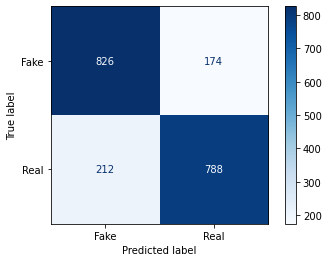

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # checkpoint_filepath = "/tmp/checkpoint"
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #     checkpoint_filepath,
    #     monitor="val_accuracy",
    #     save_best_only=True,
    #     save_weights_only=True,
    # )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
    )
    predictions = np.argmax(model.predict(X_test), axis=-1)

# Regain the original shape to evaluate predictions
    predictions = predictions.reshape(1, -1)[0]

    # Let’s also print the classification report to get more detailed results. (save it to pickel , early stopping)
    print(classification_report(y_test, predictions, target_names=['Healthy(class 0)', 'UnHealthy(class 1)']))
    print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # should be 5 for now should be 50
    epochs_range = range(80)

    plt.figure(figsize=(15, 15))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    #building the confusion matrix
    result = confusion_matrix(y_test, predictions , normalize='pred')
    print(result)
    labels = ["Fake", "Real"]
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # model.load_weights(checkpoint_filepath)
    # _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    # print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    # print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Efficient Net model

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


base_model.trainable = False

# keras tuner to find the best architecture

model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(2, activation='softmax')])

model.compile(optimizer=keras.optimizers.Adam(0.001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# callback for early stopping
# patience is the number of epochs wth no improvement after which the training will be stopped
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

 #Regain the original shape to evaluate predictions


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 132s 450ms/step - loss: 0.5699 - accuracy: 0.7005 - val_loss: 0.5103 - val_accuracy: 0.7570
Epoch 2/50
250/250 [==============================] - 110s 440ms/step - loss: 0.5001 - accuracy: 0.7577 - val_loss: 0.4791 - val_accuracy: 0.7765
Epoch 3/50
250/250 [==============================] - 110s 440ms/step - loss: 0.4811 - accuracy: 0.7588 - val_loss: 0.4596 - val_accuracy: 0.7890
Epoch 4/50
250/250 [==============================] - 110s 441ms/step - loss: 0.4650 - accuracy: 0.7760 - val_loss: 0.4435 - val_accuracy: 0.8030
Epoch 5/50
250/250 [==============================] - 110s 441ms/step - loss: 0.4506 - accuracy: 0.7901 - val_loss: 0.4369 - val_accuracy: 0.7995
Epoch 6/50
250/250 [==============================] - 110s 440ms/step - loss: 0.4413 - accuracy: 0.7935 - val_loss: 0.4295 - val_accuracy: 0.8140
Epoch 7/50
250/250 [==============================] - 110s 441ms/step - loss: 0.4397 - accuracy: 0.7966 - val_loss: 0.4124 - val_accura

NameError: ignored

Efficint net results

               precision    recall  f1-score   support

real(class 0)       0.89      0.73      0.80      1000
fake(class 1)       0.77      0.91      0.83      1000

     accuracy                           0.82      2000
    macro avg       0.83      0.82      0.82      2000
 weighted avg       0.83      0.82      0.82      2000

Accuracy:  81.8


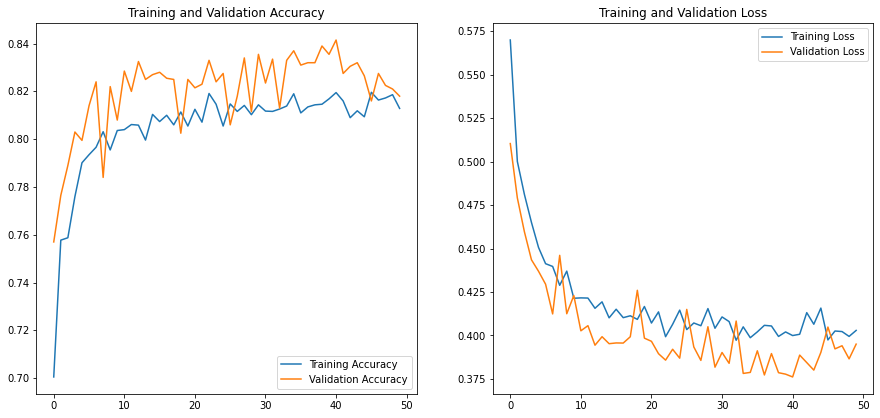

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

predictions = np.argmax(model.predict(X_test), axis=-1)
predictions = predictions.reshape(1, -1)[0]

    # Let’s also print the classification report to get more detailed results. (save it to pickel , early stopping)
print(classification_report(y_test, predictions, target_names=['real(class 0)', 'fake(class 1)']))
print("Accuracy: ", metrics.accuracy_score(y_test, predictions) * 100)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

    # should be 5 for now should be 50
epochs_range = range(50)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()